<h1 style="font-size:35px;
        color:black;
        ">Lab 3 Quantum Phase Estimation</h1>
        
## Alexandra Semposki

### Due date: 01 April 2022

Prerequisite
- [Ch.3.5 Quantum Fourier Transform](https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html)
- [Ch.3.6 Quantum Phase Estimation](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html)

Other relevant materials
- [QCQI] Michael A. Nielsen and Isaac L. Chuang. 2011. Quantum Computation and Quantum Information

In [1]:
from qiskit import *
import numpy as np
from qiskit.visualization import plot_histogram
import qiskit.tools.jupyter
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.mitigation.measurement import *
import matplotlib.pyplot as plt

C:\Users\Alexandra\AppData\Local\Temp\ipykernel_10388\35548535.py:6: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import *


<h2 style="font-size:24px;">Part 1: Performance of Quantum Phase Estimation</h2>

<br>
<div style="background: #E8E7EB; border-radius: 5px;
-moz-border-radius: 5px;">
  <p style="background: #800080;
            border-radius: 5px 5px 0px 0px;
            padding: 10px 0px 10px 10px;
            font-size:18px;
            color:white;
            "><b>Goal</b></p>
    <p style=" padding: 0px 0px 10px 10px;
              font-size:16px;">Investigate the relationship between the number of qubits required for the desired accuracy of the phase estimation with high probability.</p>
</div>


The accuracy of the estimated value through Quantum Phase Estimation (QPE) and its probability of success depend on the number of qubits employed in QPE circuits. In this lab, we examine the number of qubits required to accomplish the desired accuracy and the probability of success in determining the phase through QPE.

<h3 style="font-size: 20px">1. Find the probability of obtaining the estimation for a phase value accurate to $2^{-2}$ successfully with four counting qubits.</h3> 

<h4 style="font-size: 17px">&#128211;Step A. Set up the QPE circuit with four counting qubits and save the circuit to the variable 'qc4'.  Execute 'qc4' on a Aer simulator.  Plot the histogram of the result.</h4>

Check the QPE chapter in Qiskit textbook ( go to `3. Example: Getting More Precision` section [here](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html#3.-Example:-Getting-More-Precision-) ) for the circuit.

In [2]:
#Quantum Fourier transform
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

#Inverse Quantum Fourier Transform
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)

QFT circuit:


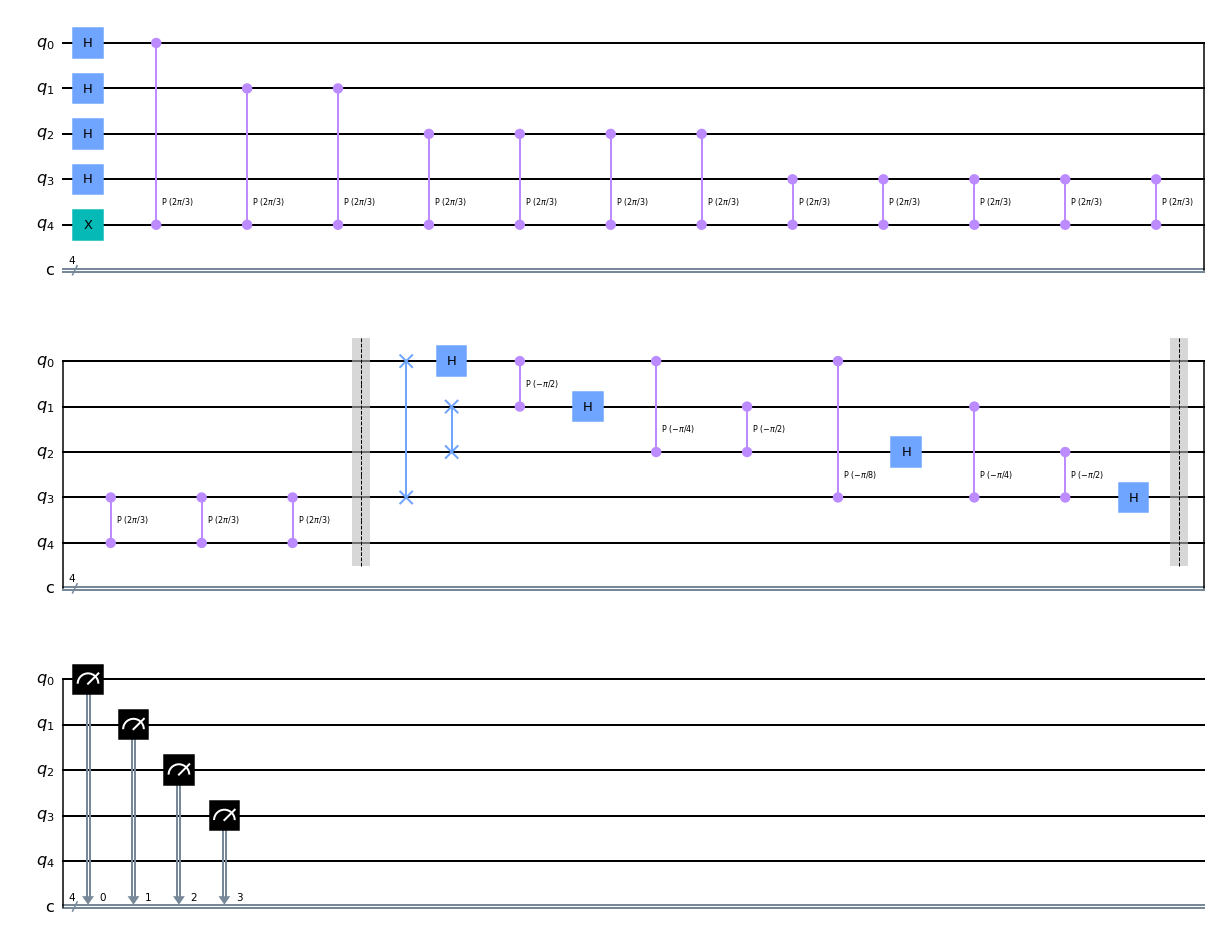

In [3]:
#import packages
import math

# Start your code to create the circuit, qc4
qc4 = QuantumCircuit(5,4)

#add the X gate to the |psi> qubit
qc4.x(4)

#add Hadamard gates to the counting qubits
for q in range(0,4):
    qc4.h(q)
    
#add unitary gates
repetitions = 1
angle = 2*math.pi/3
for counting_qubit in range(4):
    for i in range(repetitions):
        qc4.cp(angle, counting_qubit, 4);
    repetitions *= 2
    
#apply the inverse quantum Fourier transform
qc4.barrier()
qft_dagger(qc4, 4)

#measure the circuit
qc4.barrier()
for n in range(4):
    qc4.measure(n,n)

#draw the circuit to check 
print('QFT circuit:')
qc4.draw('mpl')

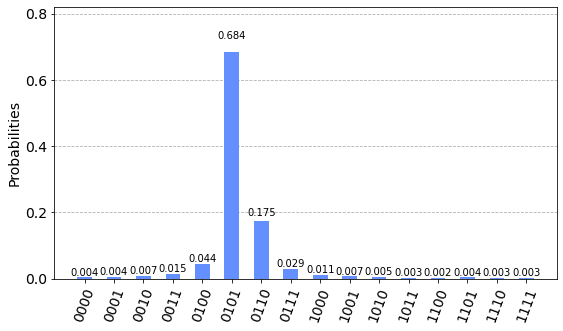

In [4]:
## Run this cell to simulate 'qc4' and to plot the histogram of the result
sim = Aer.get_backend('aer_simulator')
shots = 20000
count_qc4 = execute(qc4, sim, shots=shots).result().get_counts()
plot_histogram(count_qc4, figsize=(9,5))

Having performed `Step A` successfully, you will have obtained a distribution similar to the one shown below with the highest probability at `0101` which corresponds to the estimated $\phi$ value, `0.3125`.

![](image/L3_qc4_hist.png)

Since the number of counting qubits used for the circuit is four, the best estimated value should be accurate to $\delta = 2^{-4} = 0.0625$.  However, there are multiple possible outcomes as $\theta = 1/3$ cannot be expressed in a finite number of bits, the estimation by QPE here is not always bounded by this accuracy. 

Running the following cell shows the same histogram but with all possible estimated $\phi$ values on the x-axis.

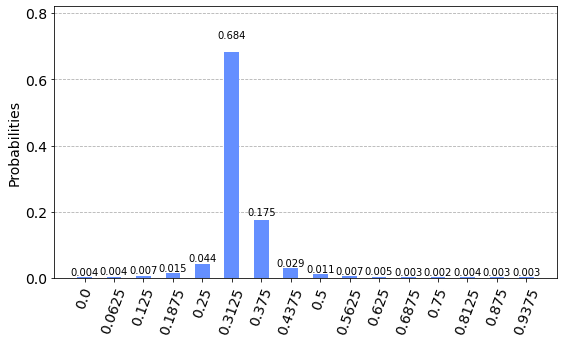

In [5]:
phi_est = np.array([round(int(key, 2)/2**n,3) for key in list(count_qc4.keys())])
key_new = list(map(str, phi_est/2))   #if I divide by 2 here, it works-->must be the fix
count_new = dict(zip(key_new, count_qc4.values()))
plot_histogram(count_new, figsize=(9,5))

**Suppose the outcome of the final measurement is $m$, and let $b$ the best estimation which is `0.3125` for this case.**
<h4 style="font-size: 17px">&#128211;Step B. Find $e$, the maximum difference in integer from the best estimation <code>0101</code> so that all the outcomes, 'm's, would approximate $\phi$ to an accuracy $2^{-2}$ when $|m - b| \leq \frac{e}{2^{t}}$. </h4>

In this case, the values of $t$ and $b$ are $4$ and $0.3125$, respectively.

For example, under $e = 1$, the considered outcomes are `0100`, `0101`, `0110` which correspond to the values of $m$: $0.25,~0.312,~0.375$, respectively, and all of them approximate the value $\frac{1}{3}$ to an accuracy $2^{-2}$.

In [6]:
## Your code goes here

#function to find the maximum integer and outcomes
def find_e(t, n, key_new):
    
    #constants
    b = 0.3125
    phi = 1/3

    #create range of integers for possible e values
    r = list(range(0,1000))

    #make key list into floats and sort in ascending order
    key = sorted([float(k) for k in key_new])
    
    #starting lists
    m = []
    condint = []
    condacc = []

    #loop over e while checking conditions
    for e in r:
        
        #check results right off; break loop if satisfied
        if any(i != 'True' for i in condint) or any(i != 'True' for i in condacc):
            emax = e-1
            #print('Maximum integer: e = {}'.format(emax))
            #print('Outcomes: m = {}'.format(m))
            break 
        
        #find m outcomes
        m = []
        bound = e / (2**t)
        mlow = b - bound
        mhigh = b + bound
        
        #find the keys that fall in the bounds
        for k in key:

            if mlow <= k and mhigh >= k:
                m.append(k)
    
        #check conditions (use Boolean arrays)
        condint = []
        condacc = []

        for i in m:

            #check the integer condition
            if np.abs(i-b) <= e/(2**t):
                condint.append('True')
            else:
                condint.append('False')     

            #check the accuracy condition
            if np.abs(phi-i) <= (2**(-n)):  
                condacc.append('True')
            else:  
                condacc.append('False')
        
    #convert outcomes back to string of keys
    m_str = [str(i) for i in m]
            
    return emax, m_str

#define inputs to test function
t = 4
n = 2

#test function
emax, m_str = find_e(t,n,key_new=key_new)

print('Maximum integer e = {}; outcomes m = {}'.format(emax, m_str))

Maximum integer e = 4; outcomes m = ['0.0625', '0.125', '0.1875', '0.25', '0.3125', '0.375', '0.4375', '0.5', '0.5625']


<h4 style="font-size: 17px">&#128211;Step C. Compute the probability of obtaining an approximation correct to an accuracy $2^{-2}$.  Verify that the computed probability value is larger or equal to $1- \frac{1}{2(2^{(t-n)}-2)}$ where $t$ is the number of counting bits and the $2^{-n}$ is the desired accuracy. </h4>

Now it is easy to evaluate the probability of the success from the histogram since all the outcomes that approximate $\phi$ to the accuracy $2^{-2}$ can be found based on the maximum difference $e$ from the best estimate. 

In [7]:
## Your code goes here
#function to evaluate probability
def probs(t, n, *args):
    
    #unpack args needed
    key, count_new, shots = args
        
    #call max_int to get emax, m
    emax, m = find_e(t, n, key)
        
    #for loop over m to pull probabilities
    probs = []
    
    for i in m:
        if i in count_new.keys():
            probs.append(count_new[i])
    
    #total probabilities
    prob_sum = sum(probs)
    
    #normalization
    prob_norm = prob_sum/shots
    
    #check the probability condition
    if prob_norm >= (1.0 - 1.0/(2.0*(2.0**(t-n) - 2.0))):
        pass
    else:
        raise ValueError('The probability is not verified.')
    
    return prob_norm

#testing the function
list_dict = [key_new, count_new, shots]
t = 4
n = 2
prob = probs(t,n, *list_dict)

print('The total probability for 2^-{} accuracy is: {}'.format(n, prob))

The total probability for 2^-2 accuracy is: 0.9762


![](image/L3_e_max.png)

![](image/L3_prob_t.png)

The following graph exhibits the relationships with different accuracy levels.  The relationship, $t=n+log(2+\frac{1}{2\epsilon})$, indicates the number of counting qubits $t$ to estimate $\phi$ to an accuracy $2^{-2}$ with probability of success at least $1-\epsilon$, as we validated above. 

In [8]:
#t,n relationship function
def y(t,n):
    
    #calculate the result
    result = 1.0 - 1.0/(2.0*(2.0**(t-n) - 2.0)) 
    
    return result

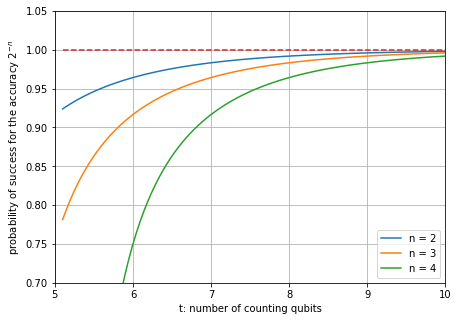

In [9]:
t = np.linspace(5.1, 10, 100)
n = [2, 3, 4]
prob_success_n = [y(t, n) for n in [2, 3, 4]]
prob_n2, prob_n3, prob_n4  = prob_success_n[0], prob_success_n[1], prob_success_n[2]
plt.figure(figsize=(7, 5))
plt.plot(t, prob_n2, t, prob_n3, t, prob_n4, t, [1]*len(t),'--' )
plt.axis([5, 10, 0.7, 1.05])
plt.xlabel('t: number of counting qubits')
plt.ylabel('probability of success for the accuracy $2^{-n}$')
plt.legend(['n = 2', 'n = 3', 'n = 4'], loc='lower right')
plt.grid(True)

![](image/L3_QPEresults.png)

![](image/L3_QPEresults_final.png)

![](image/L3_QPE_final.png)

Lab 3 completed by Alexandra Semposki on: 31 March 2022.